In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'native','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'silu',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

silu_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_norm_b25_t1_mask_t1_native_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 934)
(631390, 1)
validation
(74368, 934)
(74368, 1)
test
(85358, 934)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 934)]             0         


 dense (Dense)               (None, 1024)              957440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1646593 (6.28 MB)


Trainable params: 1646593 (6.28 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/64 [..............................] - ETA: 1:38 - loss: 0.0678 - STD: 0.0061 - MAE: 0.2510

 4/64 [>.............................] - ETA: 1s - loss: 0.0461 - STD: 0.0105 - MAE: 0.1851  

 7/64 [==>...........................] - ETA: 1s - loss: 0.0331 - STD: 0.0129 - MAE: 0.1424

10/64 [===>..........................] - ETA: 1s - loss: 0.0262 - STD: 0.0182 - MAE: 0.1225

13/64 [=====>........................] - ETA: 1s - loss: 0.0219 - STD: 0.0293 - MAE: 0.1067

16/64 [======>.......................] - ETA: 1s - loss: 0.0188 - STD: 0.0411 - MAE: 0.0970

19/64 [=======>......................] - ETA: 1s - loss: 0.0166 - STD: 0.0505 - MAE: 0.0894

22/64 [=========>....................] - ETA: 1s - loss: 0.0150 - STD: 0.0538 - MAE: 0.0833

25/64 [==========>...................] - ETA: 0s - loss: 0.0137 - STD: 0.0581 - MAE: 0.0783

28/64 [============>.................] - ETA: 0s - loss: 0.0126 - STD: 0.0632 - MAE: 0.0744

31/64 [=============>................] - ETA: 0s - loss: 0.0117 - STD: 0.0661 - MAE: 0.0709

34/64 [==============>...............] - ETA: 0s - loss: 0.0110 - STD: 0.0688 - MAE: 0.0680

37/64 [================>.............] - ETA: 0s - loss: 0.0104 - STD: 0.0714 - MAE: 0.0655

40/64 [=================>............] - ETA: 0s - loss: 0.0098 - STD: 0.0736 - MAE: 0.0633

43/64 [===================>..........] - ETA: 0s - loss: 0.0093 - STD: 0.0752 - MAE: 0.0613

44/64 [===================>..........] - ETA: 0s - loss: 0.0093 - STD: 0.0753 - MAE: 0.0607

47/64 [=====================>........] - ETA: 0s - loss: 0.0089 - STD: 0.0772 - MAE: 0.0590

50/64 [======================>.......] - ETA: 0s - loss: 0.0085 - STD: 0.0788 - MAE: 0.0576

53/64 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0797 - MAE: 0.0562

56/64 [=========================>....] - ETA: 0s - loss: 0.0078 - STD: 0.0808 - MAE: 0.0549

59/64 [==========================>...] - ETA: 0s - loss: 0.0076 - STD: 0.0819 - MAE: 0.0538

62/64 [============================>.] - ETA: 0s - loss: 0.0073 - STD: 0.0829 - MAE: 0.0528

64/64 [==============================] - 4s 45ms/step - loss: 0.0072 - STD: 0.0833 - MAE: 0.0521 - val_loss: 0.0026 - val_STD: 0.0820 - val_MAE: 0.0345


Epoch 2/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0021 - STD: 0.1030 - MAE: 0.0309

 4/64 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1039 - MAE: 0.0322

 7/64 [==>...........................] - ETA: 1s - loss: 0.0023 - STD: 0.1025 - MAE: 0.0319

10/64 [===>..........................] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

13/64 [=====>........................] - ETA: 1s - loss: 0.0023 - STD: 0.1021 - MAE: 0.0318

16/64 [======>.......................] - ETA: 1s - loss: 0.0023 - STD: 0.1019 - MAE: 0.0317

19/64 [=======>......................] - ETA: 1s - loss: 0.0023 - STD: 0.1017 - MAE: 0.0318

22/64 [=========>....................] - ETA: 1s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0319

25/64 [==========>...................] - ETA: 0s - loss: 0.0023 - STD: 0.1012 - MAE: 0.0320

27/64 [===========>..................] - ETA: 0s - loss: 0.0023 - STD: 0.1015 - MAE: 0.0321

30/64 [=============>................] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0322

33/64 [==============>...............] - ETA: 0s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0322

36/64 [===============>..............] - ETA: 0s - loss: 0.0023 - STD: 0.1018 - MAE: 0.0321

39/64 [=================>............] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0320

42/64 [==================>...........] - ETA: 0s - loss: 0.0023 - STD: 0.1016 - MAE: 0.0319

45/64 [====================>.........] - ETA: 0s - loss: 0.0022 - STD: 0.1019 - MAE: 0.0318

48/64 [=====================>........] - ETA: 0s - loss: 0.0022 - STD: 0.1020 - MAE: 0.0316

51/64 [======================>.......] - ETA: 0s - loss: 0.0022 - STD: 0.1021 - MAE: 0.0315

54/64 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.1022 - MAE: 0.0314

57/64 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0313

60/64 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.1023 - MAE: 0.0312

63/64 [============================>.] - ETA: 0s - loss: 0.0021 - STD: 0.1024 - MAE: 0.0311

64/64 [==============================] - 2s 27ms/step - loss: 0.0021 - STD: 0.1025 - MAE: 0.0311 - val_loss: 0.0020 - val_STD: 0.0926 - val_MAE: 0.0309


Epoch 3/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0018 - STD: 0.1057 - MAE: 0.0289

 4/64 [>.............................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0288

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0288

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0287

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0287

19/64 [=======>......................] - ETA: 1s - loss: 0.0018 - STD: 0.1043 - MAE: 0.0287

22/64 [=========>....................] - ETA: 1s - loss: 0.0018 - STD: 0.1049 - MAE: 0.0291

25/64 [==========>...................] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0298

28/64 [============>.................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

31/64 [=============>................] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0297

34/64 [==============>...............] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0297

37/64 [================>.............] - ETA: 0s - loss: 0.0019 - STD: 0.1036 - MAE: 0.0297

40/64 [=================>............] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0296

43/64 [===================>..........] - ETA: 0s - loss: 0.0019 - STD: 0.1035 - MAE: 0.0295

46/64 [====================>.........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

49/64 [=====================>........] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

52/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1039 - MAE: 0.0293

55/64 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0293

58/64 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0292

61/64 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0291

64/64 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291

64/64 [==============================] - 2s 27ms/step - loss: 0.0018 - STD: 0.1041 - MAE: 0.0291 - val_loss: 0.0018 - val_STD: 0.0910 - val_MAE: 0.0292


Epoch 4/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

 4/64 [>.............................] - ETA: 1s - loss: 0.0019 - STD: 0.1043 - MAE: 0.0296

 7/64 [==>...........................] - ETA: 1s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0287

10/64 [===>..........................] - ETA: 1s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0288

13/64 [=====>........................] - ETA: 1s - loss: 0.0018 - STD: 0.1044 - MAE: 0.0289

16/64 [======>.......................] - ETA: 1s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0286

19/64 [=======>......................] - ETA: 1s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0285

24/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1046 - MAE: 0.0283

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0286

32/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

35/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0290

38/64 [================>.............] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0290

41/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0291

44/64 [===================>..........] - ETA: 0s - loss: 0.0018 - STD: 0.1039 - MAE: 0.0292

47/64 [=====================>........] - ETA: 0s - loss: 0.0018 - STD: 0.1038 - MAE: 0.0293

50/64 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

53/64 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

56/64 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.1037 - MAE: 0.0294

59/64 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.1038 - MAE: 0.0294

62/64 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0293

64/64 [==============================] - 2s 27ms/step - loss: 0.0018 - STD: 0.1037 - MAE: 0.0292 - val_loss: 0.0017 - val_STD: 0.0899 - val_MAE: 0.0287


Epoch 5/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0281

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1044 - MAE: 0.0275

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0274

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

13/64 [=====>........................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

16/64 [======>.......................] - ETA: 1s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0277

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0277

22/64 [=========>....................] - ETA: 1s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0276

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1054 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0275

46/64 [====================>.........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

49/64 [=====================>........] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

52/64 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0275

55/64 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0275

58/64 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0274

61/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

64/64 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0274 - val_loss: 0.0016 - val_STD: 0.0938 - val_MAE: 0.0280


Epoch 6/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.1041 - MAE: 0.0276

 3/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0277

 6/64 [=>............................] - ETA: 1s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0275

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0271

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0269

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0278

21/64 [========>.....................] - ETA: 1s - loss: 0.0017 - STD: 0.1049 - MAE: 0.0284

24/64 [==========>...................] - ETA: 0s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0285

27/64 [===========>..................] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0289

30/64 [=============>................] - ETA: 0s - loss: 0.0018 - STD: 0.1037 - MAE: 0.0289

33/64 [==============>...............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

36/64 [===============>..............] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0290

39/64 [=================>............] - ETA: 0s - loss: 0.0018 - STD: 0.1042 - MAE: 0.0290

42/64 [==================>...........] - ETA: 0s - loss: 0.0018 - STD: 0.1040 - MAE: 0.0289

45/64 [====================>.........] - ETA: 0s - loss: 0.0018 - STD: 0.1041 - MAE: 0.0288

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1040 - MAE: 0.0287

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1041 - MAE: 0.0286

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1042 - MAE: 0.0285

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0284

60/64 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1043 - MAE: 0.0283

63/64 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283

64/64 [==============================] - 2s 27ms/step - loss: 0.0017 - STD: 0.1044 - MAE: 0.0283 - val_loss: 0.0016 - val_STD: 0.0917 - val_MAE: 0.0278


Epoch 7/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0986 - MAE: 0.0274

 4/64 [>.............................] - ETA: 1s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0274

 7/64 [==>...........................] - ETA: 1s - loss: 0.0016 - STD: 0.1039 - MAE: 0.0272

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1043 - MAE: 0.0271

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0270

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0269

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0269

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0268

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0016 - val_STD: 0.0964 - val_MAE: 0.0281


Epoch 8/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0259

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1049 - MAE: 0.0260

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0270

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0270

16/64 [======>.......................] - ETA: 1s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0274

18/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0273

21/64 [========>.....................] - ETA: 1s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0273

24/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0271

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0271

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0270

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0269

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0268

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0267

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267 - val_loss: 0.0015 - val_STD: 0.0929 - val_MAE: 0.0271


Epoch 9/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0016 - STD: 0.1046 - MAE: 0.0272

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0270

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0269

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0268

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1050 - MAE: 0.0267

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0267

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0267

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

45/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

48/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0266

51/64 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

54/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0265

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265 - val_loss: 0.0018 - val_STD: 0.0986 - val_MAE: 0.0294


Epoch 10/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1106 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0257

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0257

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0258

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0259

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1060 - MAE: 0.0268

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0268

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1058 - MAE: 0.0267

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1059 - MAE: 0.0267

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0268

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0268

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0269

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268 - val_loss: 0.0018 - val_STD: 0.0990 - val_MAE: 0.0288


Epoch 11/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1108 - MAE: 0.0252

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1078 - MAE: 0.0257

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1075 - MAE: 0.0257

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1079 - MAE: 0.0259

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1065 - MAE: 0.0260

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0261

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1066 - MAE: 0.0262

22/64 [=========>....................] - ETA: 1s - loss: 0.0015 - STD: 0.1064 - MAE: 0.0263

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1062 - MAE: 0.0262

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0261

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1063 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0262

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0262

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0261

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0262

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1059 - MAE: 0.0262 - val_loss: 0.0015 - val_STD: 0.0898 - val_MAE: 0.0270


Epoch 12/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.0962 - MAE: 0.0261

 4/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

 7/64 [==>...........................] - ETA: 1s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0266

10/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0267

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0265

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

19/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

22/64 [=========>....................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

25/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

28/64 [============>.................] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

31/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0265

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

43/64 [===================>..........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0263

57/64 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0263

60/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

63/64 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1056 - MAE: 0.0262 - val_loss: 0.0017 - val_STD: 0.0962 - val_MAE: 0.0285


Epoch 13/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1076 - MAE: 0.0255

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0255

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0255

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0257

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256 - val_loss: 0.0015 - val_STD: 0.0970 - val_MAE: 0.0268


Epoch 14/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0263

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1070 - MAE: 0.0253

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0257

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0256

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0256

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0255

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0253

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0253

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0254

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0255 - val_loss: 0.0021 - val_STD: 0.0995 - val_MAE: 0.0306


Epoch 15/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0254

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0259

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1040 - MAE: 0.0260

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0262

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1045 - MAE: 0.0261

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0258

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0259

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0258

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0258

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0258

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0258

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0259

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1062 - MAE: 0.0259

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1061 - MAE: 0.0259 - val_loss: 0.0016 - val_STD: 0.0982 - val_MAE: 0.0271


Epoch 16/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0013 - STD: 0.1052 - MAE: 0.0248

 3/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1058 - MAE: 0.0252

 6/64 [=>............................] - ETA: 1s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0251

 9/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0251

12/64 [====>.........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0250

15/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0249

18/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0249

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0248

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0249

27/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1071 - MAE: 0.0250

30/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

33/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0257

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0264

39/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0278

42/64 [==================>...........] - ETA: 0s - loss: 0.0016 - STD: 0.1055 - MAE: 0.0283

45/64 [====================>.........] - ETA: 0s - loss: 0.0017 - STD: 0.1051 - MAE: 0.0284

48/64 [=====================>........] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0285

51/64 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1052 - MAE: 0.0286

54/64 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1050 - MAE: 0.0286

57/64 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1053 - MAE: 0.0286

60/64 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1050 - MAE: 0.0285

63/64 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0284

64/64 [==============================] - 2s 27ms/step - loss: 0.0016 - STD: 0.1052 - MAE: 0.0284 - val_loss: 0.0018 - val_STD: 0.0957 - val_MAE: 0.0300


Epoch 17/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0015 - STD: 0.1036 - MAE: 0.0264

 3/64 [>.............................] - ETA: 1s - loss: 0.0015 - STD: 0.1013 - MAE: 0.0265

 6/64 [=>............................] - ETA: 1s - loss: 0.0015 - STD: 0.1051 - MAE: 0.0266

 9/64 [===>..........................] - ETA: 1s - loss: 0.0015 - STD: 0.1048 - MAE: 0.0265

12/64 [====>.........................] - ETA: 1s - loss: 0.0015 - STD: 0.1046 - MAE: 0.0264

15/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0265

18/64 [=======>......................] - ETA: 1s - loss: 0.0015 - STD: 0.1052 - MAE: 0.0264

21/64 [========>.....................] - ETA: 1s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

24/64 [==========>...................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

27/64 [===========>..................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

30/64 [=============>................] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

33/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0264

36/64 [===============>..............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

39/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0264

42/64 [==================>...........] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0264

45/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

48/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

51/64 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

54/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

57/64 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

60/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

63/64 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0262

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262 - val_loss: 0.0014 - val_STD: 0.0946 - val_MAE: 0.0268


Epoch 18/10000


 1/64 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1000 - MAE: 0.0267

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1046 - MAE: 0.0262

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0261

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0259

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0260

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1053 - MAE: 0.0260

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0261

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0262

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0263

34/64 [==============>...............] - ETA: 0s - loss: 0.0015 - STD: 0.1055 - MAE: 0.0263

37/64 [================>.............] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0263

40/64 [=================>............] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0263

43/64 [===================>..........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

46/64 [====================>.........] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0262

49/64 [=====================>........] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0261

52/64 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

55/64 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0260

58/64 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0259

61/64 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

64/64 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259

64/64 [==============================] - 2s 27ms/step - loss: 0.0014 - STD: 0.1058 - MAE: 0.0259 - val_loss: 0.0021 - val_STD: 0.1026 - val_MAE: 0.0307


Epoch 19/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1111 - MAE: 0.0260

 3/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1063 - MAE: 0.0256

 6/64 [=>............................] - ETA: 1s - loss: 0.0014 - STD: 0.1064 - MAE: 0.0255

 9/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0256

12/64 [====>.........................] - ETA: 1s - loss: 0.0014 - STD: 0.1066 - MAE: 0.0255

15/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1067 - MAE: 0.0254

18/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0253

21/64 [========>.....................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0252

24/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

26/64 [===========>..................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

29/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

32/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0251

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0250

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0251

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0251

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - STD: 0.1064 - MAE: 0.0251 - val_loss: 0.0014 - val_STD: 0.0923 - val_MAE: 0.0264


Epoch 20/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0997 - MAE: 0.0243

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0256

 7/64 [==>...........................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0254

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0260

13/64 [=====>........................] - ETA: 1s - loss: 0.0014 - STD: 0.1060 - MAE: 0.0261

16/64 [======>.......................] - ETA: 1s - loss: 0.0014 - STD: 0.1051 - MAE: 0.0259

19/64 [=======>......................] - ETA: 1s - loss: 0.0014 - STD: 0.1052 - MAE: 0.0258

22/64 [=========>....................] - ETA: 1s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0257

25/64 [==========>...................] - ETA: 0s - loss: 0.0014 - STD: 0.1054 - MAE: 0.0256

28/64 [============>.................] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0256

31/64 [=============>................] - ETA: 0s - loss: 0.0014 - STD: 0.1055 - MAE: 0.0255

34/64 [==============>...............] - ETA: 0s - loss: 0.0014 - STD: 0.1056 - MAE: 0.0255

37/64 [================>.............] - ETA: 0s - loss: 0.0014 - STD: 0.1058 - MAE: 0.0255

40/64 [=================>............] - ETA: 0s - loss: 0.0014 - STD: 0.1059 - MAE: 0.0255

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1059 - MAE: 0.0254

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0254

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0254

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

55/64 [========================>.....] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

58/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0252

61/64 [===========================>..] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0252

64/64 [==============================] - ETA: 0s - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251

64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - STD: 0.1063 - MAE: 0.0251 - val_loss: 0.0015 - val_STD: 0.0987 - val_MAE: 0.0268


Epoch 21/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0252

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1060 - MAE: 0.0247

 6/64 [=>............................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0246

 9/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0244

12/64 [====>.........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

15/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

18/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

21/64 [========>.....................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

23/64 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

26/64 [===========>..................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

29/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

32/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0244

35/64 [===============>..............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0245

38/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246

41/64 [==================>...........] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

44/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

47/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1064 - MAE: 0.0247

50/64 [======================>.......] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0247

53/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

56/64 [=========================>....] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

59/64 [==========================>...] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0247

62/64 [============================>.] - ETA: 0s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0246

64/64 [==============================] - 2s 27ms/step - loss: 0.0013 - STD: 0.1068 - MAE: 0.0246 - val_loss: 0.0017 - val_STD: 0.1005 - val_MAE: 0.0275


Epoch 22/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1082 - MAE: 0.0237

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0240

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0242

13/64 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0242

16/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

19/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

22/64 [=========>....................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0245 - val_loss: 0.0016 - val_STD: 0.0976 - val_MAE: 0.0274


Epoch 23/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1048 - MAE: 0.0265

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1051 - MAE: 0.0259

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0258

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0256

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0255

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0253

22/64 [=========>....................] - ETA: 0s - loss: 0.0013 - STD: 0.1068 - MAE: 0.0252

25/64 [==========>...................] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0252

28/64 [============>.................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0252

31/64 [=============>................] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0251

34/64 [==============>...............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0250

37/64 [================>.............] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0249

40/64 [=================>............] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

43/64 [===================>..........] - ETA: 0s - loss: 0.0013 - STD: 0.1066 - MAE: 0.0248

46/64 [====================>.........] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0248

49/64 [=====================>........] - ETA: 0s - loss: 0.0013 - STD: 0.1065 - MAE: 0.0247

52/64 [=======================>......] - ETA: 0s - loss: 0.0013 - STD: 0.1067 - MAE: 0.0247

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0246

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0246

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0246

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0246

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0246 - val_loss: 0.0014 - val_STD: 0.0949 - val_MAE: 0.0258


Epoch 24/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0014 - STD: 0.1007 - MAE: 0.0257

 4/64 [>.............................] - ETA: 1s - loss: 0.0013 - STD: 0.1053 - MAE: 0.0249

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1055 - MAE: 0.0250

10/64 [===>..........................] - ETA: 1s - loss: 0.0014 - STD: 0.1057 - MAE: 0.0256

13/64 [=====>........................] - ETA: 1s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

16/64 [======>.......................] - ETA: 1s - loss: 0.0015 - STD: 0.1049 - MAE: 0.0274

19/64 [=======>......................] - ETA: 1s - loss: 0.0016 - STD: 0.1061 - MAE: 0.0275

22/64 [=========>....................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0275

25/64 [==========>...................] - ETA: 0s - loss: 0.0016 - STD: 0.1053 - MAE: 0.0276

28/64 [============>.................] - ETA: 0s - loss: 0.0016 - STD: 0.1047 - MAE: 0.0278

31/64 [=============>................] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0279

34/64 [==============>...............] - ETA: 0s - loss: 0.0016 - STD: 0.1048 - MAE: 0.0278

37/64 [================>.............] - ETA: 0s - loss: 0.0016 - STD: 0.1052 - MAE: 0.0276

40/64 [=================>............] - ETA: 0s - loss: 0.0016 - STD: 0.1051 - MAE: 0.0275

43/64 [===================>..........] - ETA: 0s - loss: 0.0016 - STD: 0.1049 - MAE: 0.0274

46/64 [====================>.........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0272

49/64 [=====================>........] - ETA: 0s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0271

52/64 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0269

55/64 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0268

58/64 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1054 - MAE: 0.0267

61/64 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1056 - MAE: 0.0266

64/64 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265

64/64 [==============================] - 2s 27ms/step - loss: 0.0015 - STD: 0.1057 - MAE: 0.0265 - val_loss: 0.0016 - val_STD: 0.0985 - val_MAE: 0.0274


Epoch 25/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0238

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0243

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1062 - MAE: 0.0242

13/64 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0243

16/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0242

19/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0243

22/64 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1064 - MAE: 0.0243

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0243

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0242

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0242

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242 - val_loss: 0.0017 - val_STD: 0.1015 - val_MAE: 0.0270


Epoch 26/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0012 - STD: 0.1088 - MAE: 0.0238

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1086 - MAE: 0.0238

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1085 - MAE: 0.0238

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1081 - MAE: 0.0238

13/64 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1078 - MAE: 0.0237

16/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0237

19/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1077 - MAE: 0.0236

22/64 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0237

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0238

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0238

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1074 - MAE: 0.0239

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1073 - MAE: 0.0239

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0239

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241 - val_loss: 0.0017 - val_STD: 0.0935 - val_MAE: 0.0290


Epoch 27/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.0984 - MAE: 0.0250

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0244

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1054 - MAE: 0.0243

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0245

13/64 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0246

16/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1061 - MAE: 0.0246

19/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0246

22/64 [=========>....................] - ETA: 0s - loss: 0.0012 - STD: 0.1065 - MAE: 0.0245

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0243

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0242

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242 - val_loss: 0.0019 - val_STD: 0.1024 - val_MAE: 0.0284


Epoch 28/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0011 - STD: 0.1104 - MAE: 0.0234

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1063 - MAE: 0.0237

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1075 - MAE: 0.0237

10/64 [===>..........................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

13/64 [=====>........................] - ETA: 1s - loss: 0.0011 - STD: 0.1070 - MAE: 0.0235

16/64 [======>.......................] - ETA: 1s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

19/64 [=======>......................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0235

22/64 [=========>....................] - ETA: 1s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

25/64 [==========>...................] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

28/64 [============>.................] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

30/64 [=============>................] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

33/64 [==============>...............] - ETA: 0s - loss: 0.0011 - STD: 0.1074 - MAE: 0.0234

36/64 [===============>..............] - ETA: 0s - loss: 0.0011 - STD: 0.1073 - MAE: 0.0234

39/64 [=================>............] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0234

41/64 [==================>...........] - ETA: 0s - loss: 0.0011 - STD: 0.1071 - MAE: 0.0235

44/64 [===================>..........] - ETA: 0s - loss: 0.0011 - STD: 0.1072 - MAE: 0.0236

47/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0236

50/64 [======================>.......] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0237

53/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

56/64 [=========================>....] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

59/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

62/64 [============================>.] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242 - val_loss: 0.0026 - val_STD: 0.1039 - val_MAE: 0.0335


Epoch 29/10000


 1/64 [..............................] - ETA: 2s - loss: 0.0014 - STD: 0.1127 - MAE: 0.0264

 4/64 [>.............................] - ETA: 1s - loss: 0.0014 - STD: 0.1083 - MAE: 0.0258

 7/64 [==>...........................] - ETA: 1s - loss: 0.0013 - STD: 0.1062 - MAE: 0.0253

10/64 [===>..........................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0251

13/64 [=====>........................] - ETA: 1s - loss: 0.0013 - STD: 0.1070 - MAE: 0.0250

16/64 [======>.......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

19/64 [=======>......................] - ETA: 1s - loss: 0.0013 - STD: 0.1069 - MAE: 0.0247

22/64 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

25/64 [==========>...................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0245

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0242

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0241

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0241

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0241

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0240

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0239

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0239

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1072 - MAE: 0.0238 - val_loss: 0.0015 - val_STD: 0.0986 - val_MAE: 0.0264


Epoch 30/10000


 1/64 [..............................] - ETA: 3s - loss: 0.0013 - STD: 0.1013 - MAE: 0.0250

 4/64 [>.............................] - ETA: 1s - loss: 0.0012 - STD: 0.1047 - MAE: 0.0239

 7/64 [==>...........................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

10/64 [===>..........................] - ETA: 1s - loss: 0.0012 - STD: 0.1071 - MAE: 0.0236

13/64 [=====>........................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0238

16/64 [======>.......................] - ETA: 1s - loss: 0.0012 - STD: 0.1066 - MAE: 0.0237

19/64 [=======>......................] - ETA: 1s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0237

22/64 [=========>....................] - ETA: 1s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0237

25/64 [==========>...................] - ETA: 0s - loss: 0.0011 - STD: 0.1068 - MAE: 0.0237

28/64 [============>.................] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0237

31/64 [=============>................] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0238

34/64 [==============>...............] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0240

37/64 [================>.............] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

40/64 [=================>............] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0243

43/64 [===================>..........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

46/64 [====================>.........] - ETA: 0s - loss: 0.0012 - STD: 0.1067 - MAE: 0.0244

49/64 [=====================>........] - ETA: 0s - loss: 0.0012 - STD: 0.1068 - MAE: 0.0244

52/64 [=======================>......] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0244

55/64 [========================>.....] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

58/64 [==========================>...] - ETA: 0s - loss: 0.0012 - STD: 0.1069 - MAE: 0.0243

61/64 [===========================>..] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0243

64/64 [==============================] - ETA: 0s - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242

64/64 [==============================] - 2s 27ms/step - loss: 0.0012 - STD: 0.1070 - MAE: 0.0242 - val_loss: 0.0018 - val_STD: 0.1026 - val_MAE: 0.0278


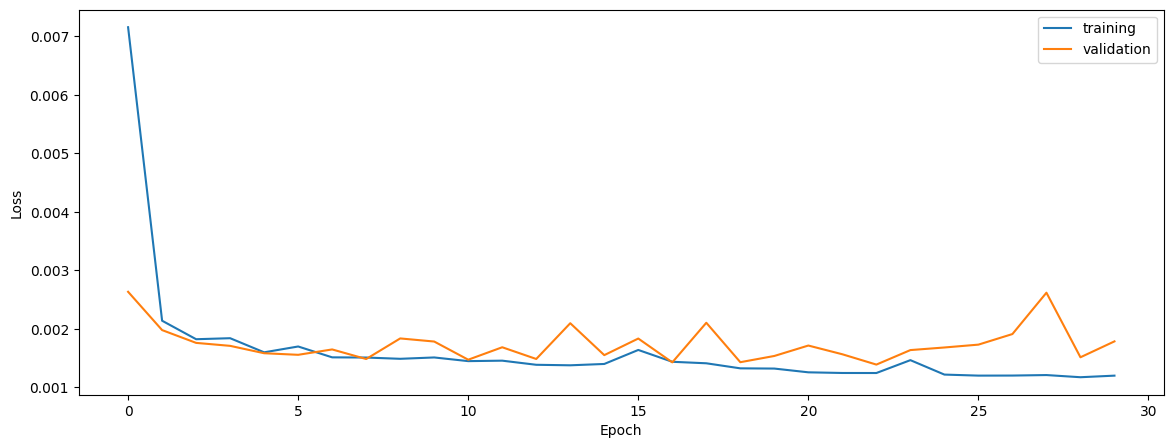

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.9525392839572459
0.9580551940629692
0.9451400282008027


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.9512715737450596
0.953694570197087
0.9492361246174507


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.9569195307233724
0.9545427252302084
0.9597436511192684


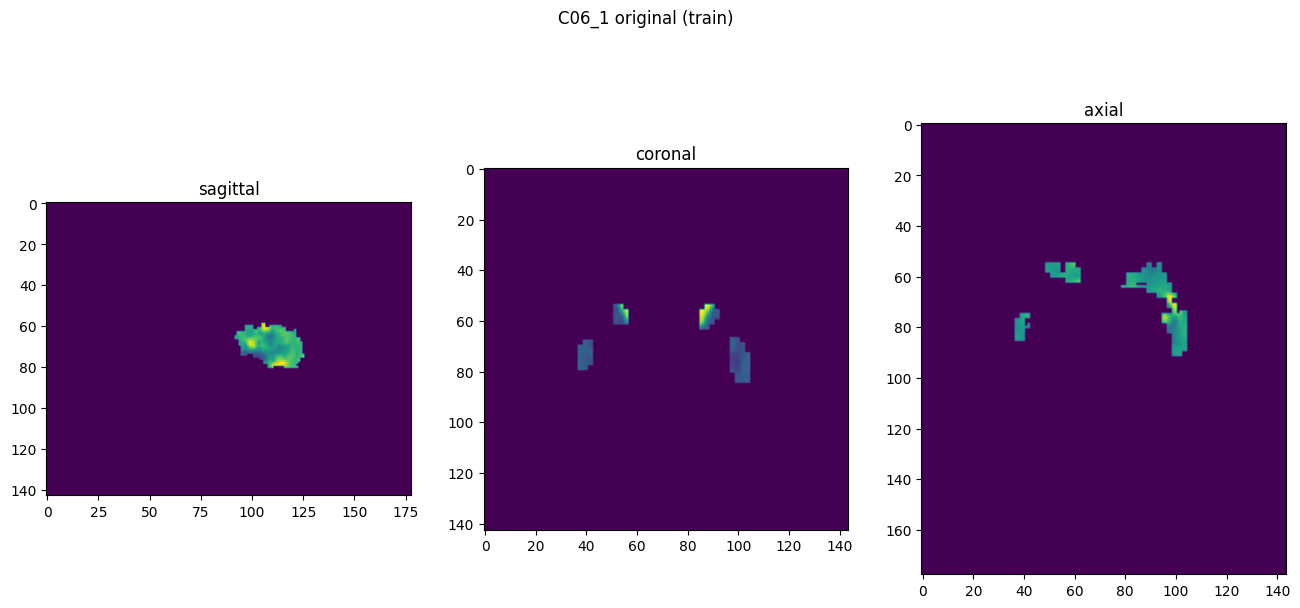

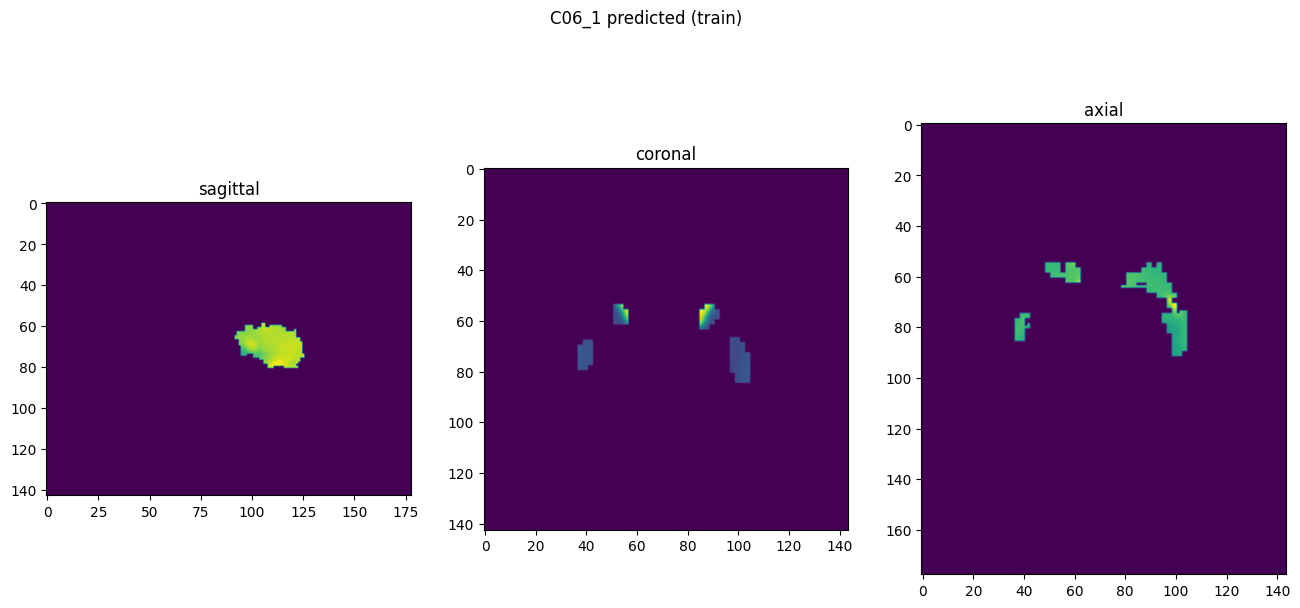

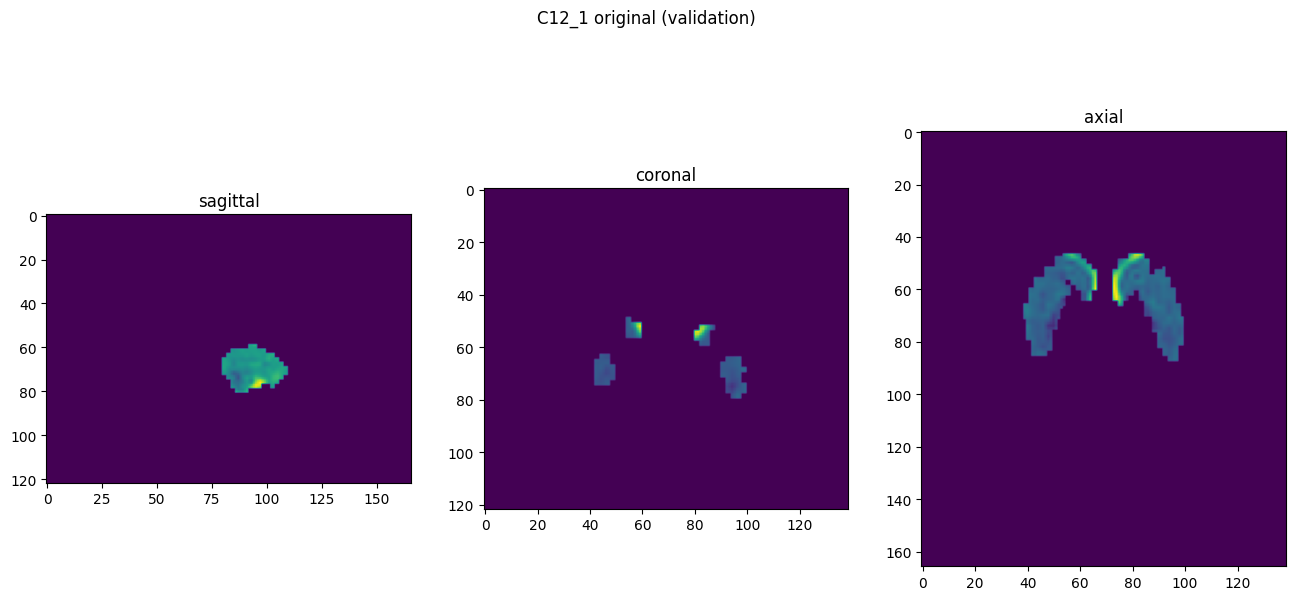

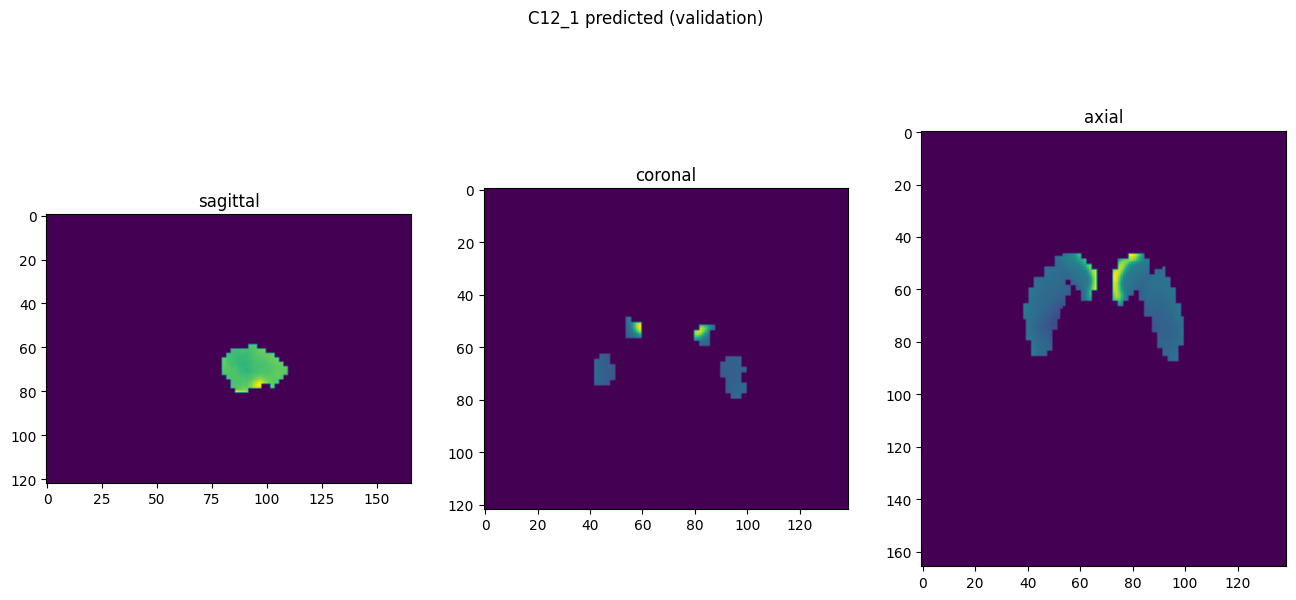

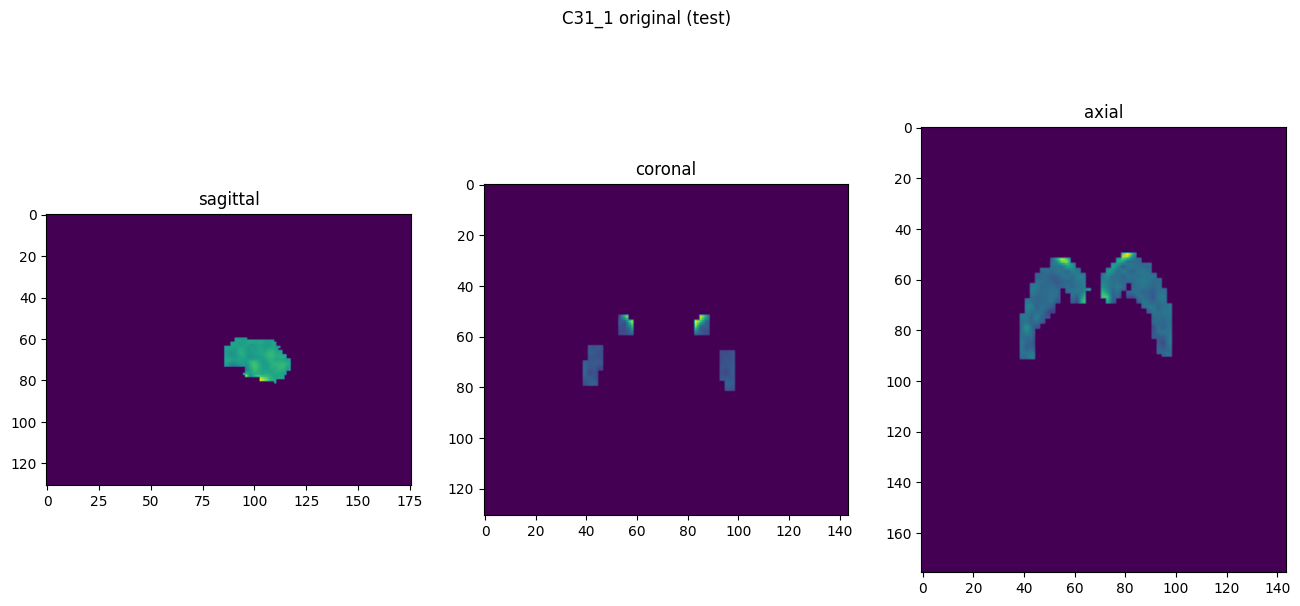

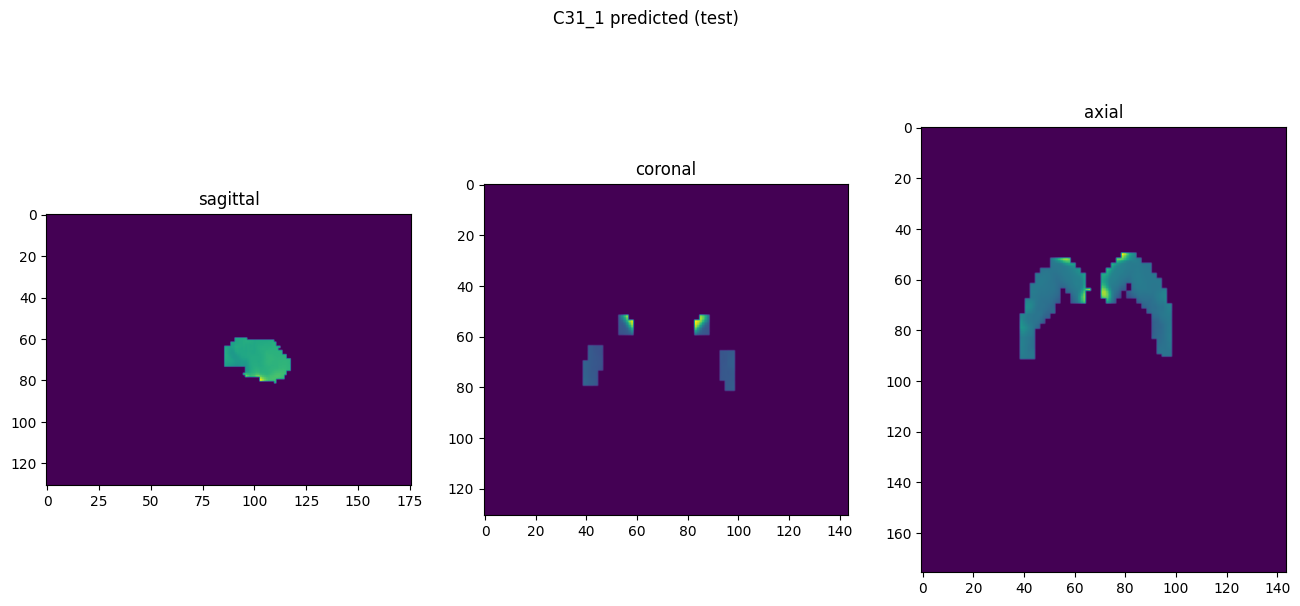

In [10]:
showResults(model, gen, threshold=None, background=False)